<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395 Introducción a las redes neuronales artificiales and deep learning 2022-1 </h1>

<H3 align='center'> Ayudantía III: Redes Recurrentes </H3>

----

<H3 align='center'> <b>Profesores: Ricardo Ñanculef - Ignacio Loayza </b> </H3>
<H3 align='center'> <b>Ayudantes: Francisco Andrades - Mario Mallea </b> </H3>



<hr style="height:2px;border:none"/>

▶ video: https://us02web.zoom.us/rec/share/kFemX6fmI7Daj6dNpB_zAVb_EcBWJJYBP5eJGtB0aJndJOAe7NMMS2LtMpx5FEnf.ruRCAC5TfhsYayqj
Código de acceso: B%?^?q9R

# 📚 Repaso 📚

fuente: https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

Tipos de arquitecturas

*   One-to-one

$T_x=T_y=1$

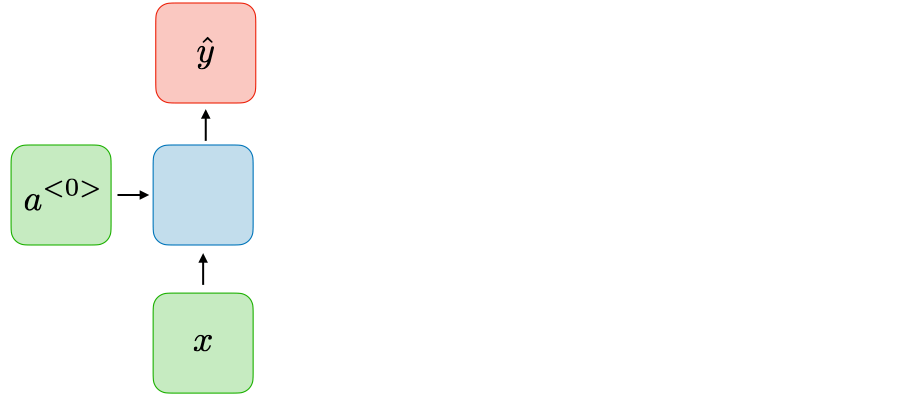






*   One-to-many

$T_x=1, T_y>1$

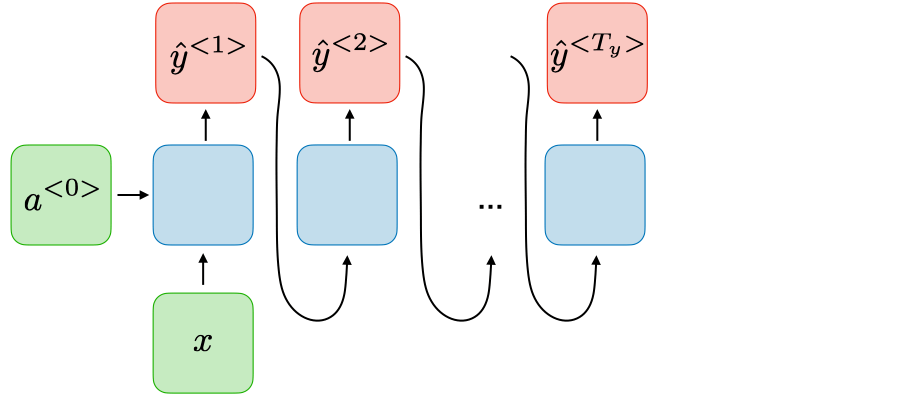

Ej: generación de musica





*   Many-to-one

$T_x>1, T_y=1$

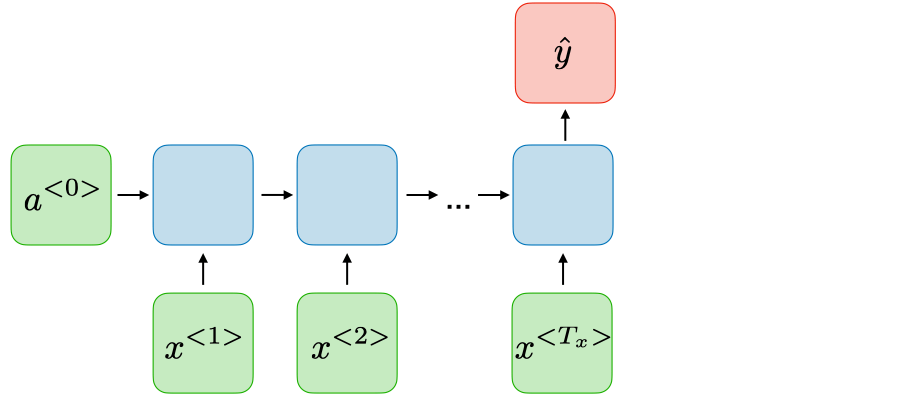

Ej: Clasificación de series en general 



*   Many-to-many
$T_x=T_y$ 
​
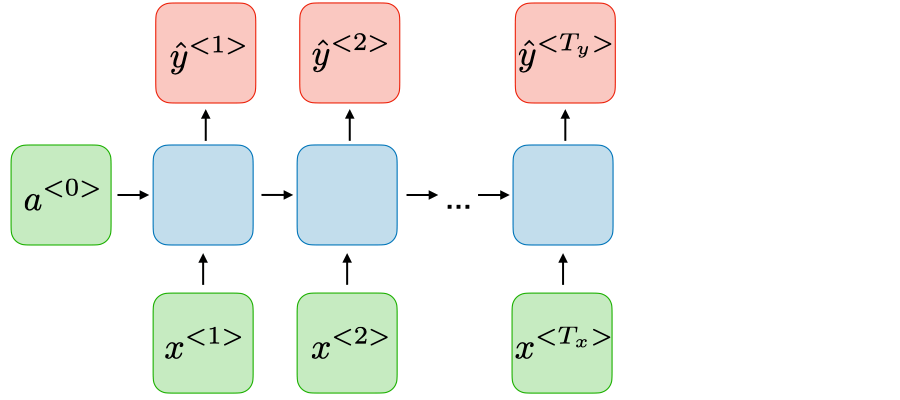

Ej: Regresión o clasificación con mismo tamaño de ventana

*   Many-to-many

$T_x\neq T_y$

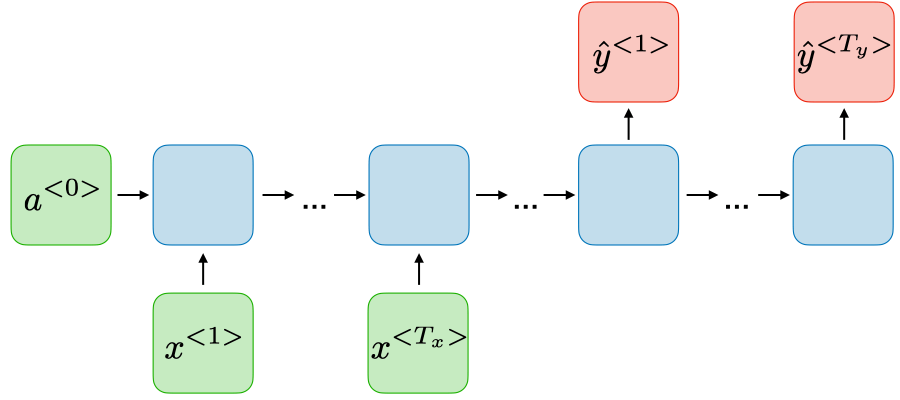

Traducción







Dentro de la caja:

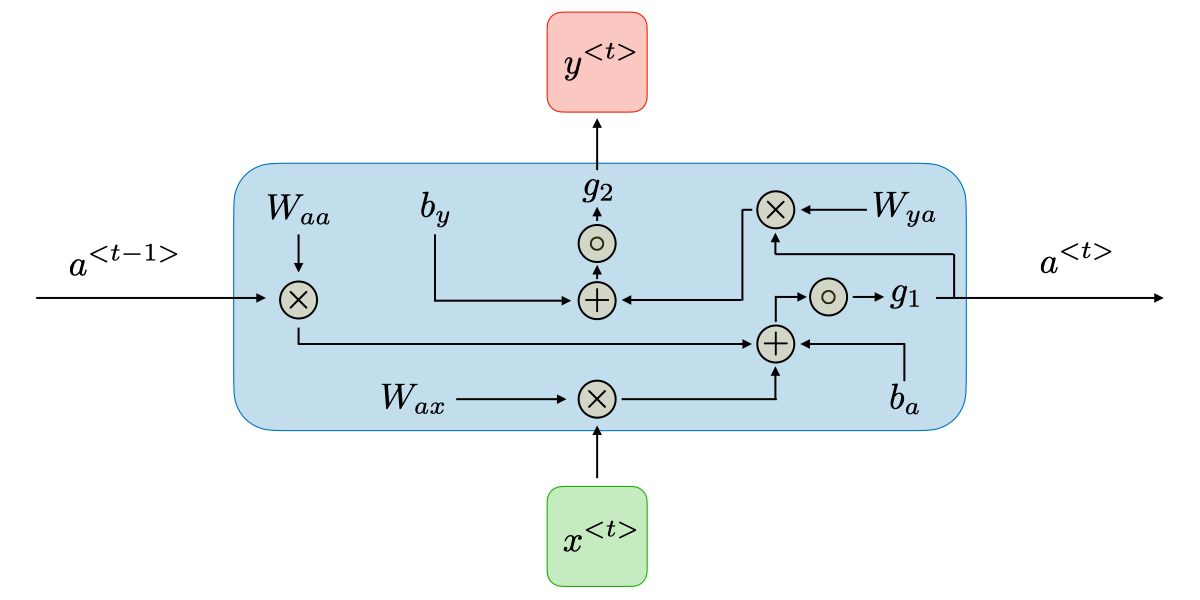

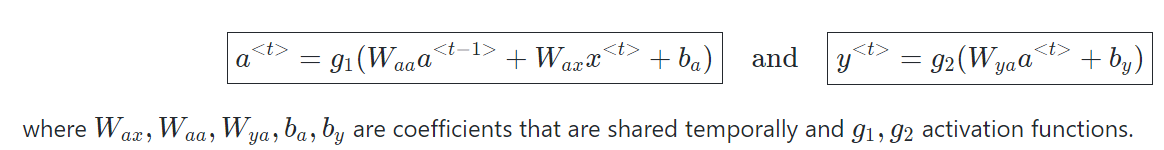

Puntos claves:

*   Podemos procesar secuencias de cualquier largo, sin aumentar la cantidad de parámetros (pesos compartidos en el tiempo)

Si n es la dimensión de la capa oculta, m la dimensión del input(no largo) y k la dimensión del output.

Las matrices de pesos del input (mn), de estado (n*n +n)  y de output (kn+k).

Mientras que en una red ff, habría que hacer flatten osea solo el input tiene dimensión m* largo secuencia. 

*   Más lento (si o si ocupen GPU) y es dificil recordar en secuencias largas (se desvanece el gradiente)



Una solución: 

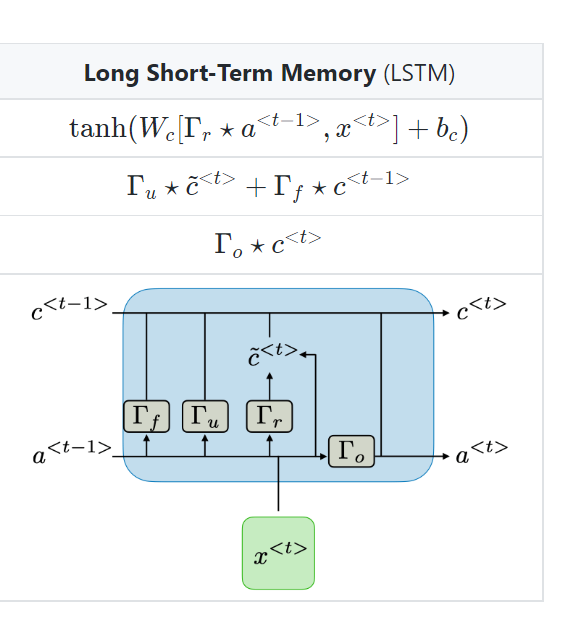

Estrellita, es producto de Hadamar o elementwise. Las compuertas se ajustan para distintos própositos. 

aquí los parámetros son igual que antes pero por 4 (por capa lstm)

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# 📑 Clasificación de texto 📑

Fuente: https://www.tensorflow.org/text/tutorials/text_classification_rnn

In [2]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [3]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Enormous fun for both adults and children, this film works on numerous levels: there is everything from car crashes and cake in the face to some very good (yet subtle) jokes for adults.<br /><br />Glenn Close is at her sublimely evil best as Cruella (`call me Ella') De Ville.<br /><br />After three years in Dr. Pavlov's Behaviour Modification Clinic she is cured of her desire for fur \xc2\x96 even the puppy-skin fur she had so intensely desired. She even has all of her fur coats placed in the dungeon of the extraordinary castle she inhabits.<br /><br />But it wouldn't be a \xc2\x91Dalmatian' movie without the subterfuge and machinations of Cruella and you know that something will change her behaviour modification. And now she needs one extra puppy (hence 102 Dalmatians) to complete her nefarious scheme this time round.<br /><br />Ioan Gruffudd is instantly appealing as the hero of the film that runs the `Second Chance' dog shelter. Though he was in `Titanic' and in last year

In [9]:
VOCAB_SIZE = 1000
# representaciones codificadas NO ENTRENABLE
encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE) 
encoder.adapt(train_dataset.map(lambda text, label: text))

El .adapt método establece el vocabulario de la capa. Aquí están las primeras 20 fichas. Después del relleno y los tokens desconocidos, se ordenan por frecuencia:

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

El tamaño limitado del vocabulario y la falta de respaldo basado en caracteres dan como resultado algunos tokens desconocidos.

Una vez que se establece el vocabulario, la capa puede codificar texto en índices. Los tensores de índices se 0-padding hacia la secuencia más larga en el lote (a menos que establezca un fijo output_sequence_length ):

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 250,  16, ...,   0,   0,   0],
       [ 45,  23, 344, ...,   0,   0,   0],
       [ 11,   7,   4, ...,   0,   0,   0]])

## Modelo

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64, mask_zero=True),
     # Use masking to handle the variable sequence lengths
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True))
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

Después del codificador hay una capa de incrustación. Esta convierte las secuencias de índices de palabras en secuencias de vectores (denso), estos si son entrenables. Después del entrenamiento (con suficientes datos), las palabras con significados similares a menudo tienen vectores similares.

Este índice de búsqueda es mucho más eficiente que la operación equivalente de pasar un vector codificado a través de una capa tf.keras.layers.Dense 

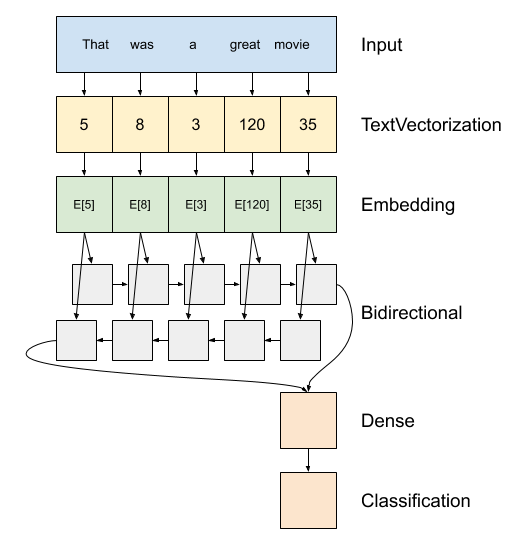

Capas recurrentes Keras tienen dos modos disponibles de return_sequences :

* False(predeterminado): devuelve sólo el último valor de salida para cada secuencia de entrada (un tensor 2D de forma (batch_size, output_features)).

* True (para aumentar en profundidad ): se devuelven las secuencias completas de salidas sucesivas para cada paso de tiempo (un tensor 3D de la forma (batch_size, timesteps, output_features) ).

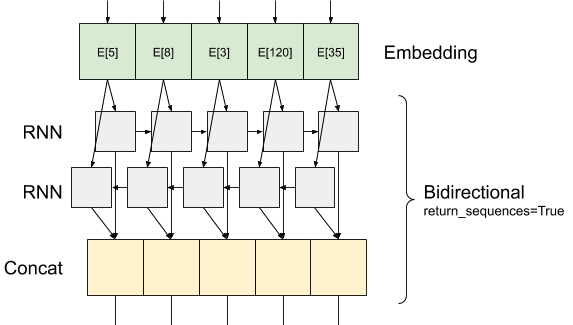

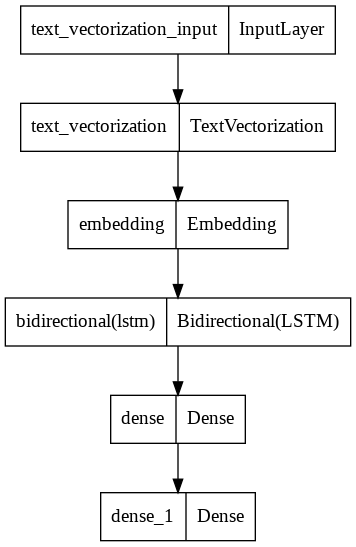

In [13]:
tf.keras.utils.plot_model(model)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-trai

Cómo se llega a los parámetros de la capa oculta ?

2*4 *(64 *64+ 64 + 64 * 64)



In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.00146267]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.00146267]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 47s 85ms/step - loss: 0.6442 - accuracy: 0.5638 - val_loss: 0.4828 - val_accuracy: 0.7443
Epoch 2/10
391/391 [==============================] - 32s 80ms/step - loss: 0.4178 - accuracy: 0.8053 - val_loss: 0.3916 - val_accuracy: 0.8188
Epoch 3/10
391/391 [==============================] - 34s 85ms/step - loss: 0.3574 - accuracy: 0.8444 - val_loss: 0.3510 - val_accuracy: 0.8396
Epoch 4/10
391/391 [==============================] - 31s 79ms/step - loss: 0.3307 - accuracy: 0.8575 - val_loss: 0.3428 - val_accuracy: 0.8443
Epoch 5/10
391/391 [==============================] - 32s 80ms/step - loss: 0.3182 - accuracy: 0.8665 - val_loss: 0.3389 - val_accuracy: 0.8438
Epoch 6/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3075 - accuracy: 0.8696 - val_loss: 0.3248 - val_accuracy: 0.8536
Epoch 7/10
391/391 [==============================] - 33s 82ms/step - loss: 0.3025 - accuracy: 0.8720 - val_loss: 0.3227 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 18s 46ms/step - loss: 0.3163 - accuracy: 0.8635
Test Loss: 0.31632301211357117
Test Accuracy: 0.8635200262069702


(0.0, 0.661529628932476)

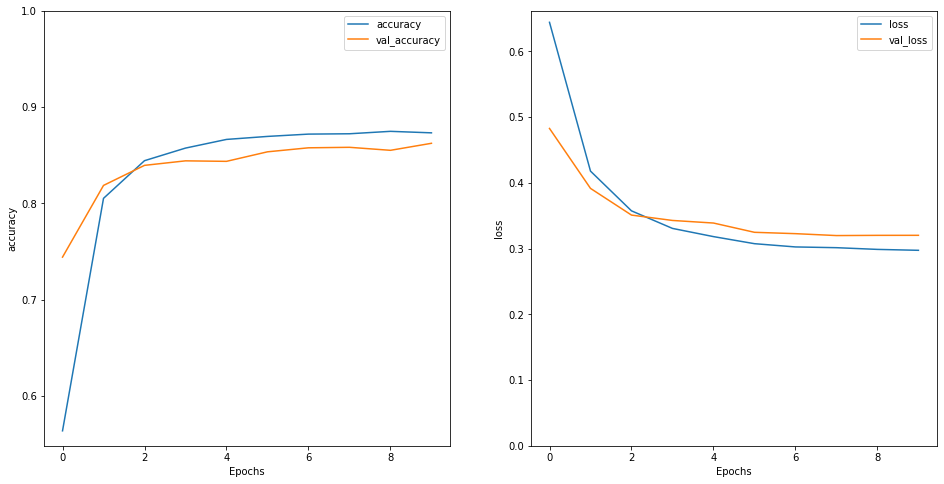

In [20]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# 🎵 Speech Emotion Detection 🎵

Fuentes : https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Tess = '/content/drive/MyDrive/dataset_ml/TESS Toronto emotional speech set data/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dos actrices (de 26 y 64 años de edad) pronunciaron un conjunto de 200 palabras objetivo en la frase portadora "Di la palabra _ " y se realizaron grabaciones del conjunto que representan cada una de las siete emociones (ira 😒, asco 🤮, miedo 😨, felicidad 😀, sorpresa agradable 🙂, tristeza 😞 y neutral 😐) Hay 2800 puntos de datos (archivos de audio) en total.

El conjunto de datos está organizado de tal manera que cada una de las dos actrices y sus emociones están contenidas dentro de su propia carpeta. Y dentro de eso, se pueden encontrar los archivos de audio de las 200 palabras objetivo. El formato del archivo de audio es un formato WAV.

https://tspace.library.utoronto.ca/handle/1807/24487

In [22]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    print(dir)
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

OAF_Pleasant_surprise
OAF_disgust
YAF_angry
YAF_disgust
OAF_happy
OAF_Sad
OAF_angry
OAF_neutral
OAF_Fear
YAF_happy
YAF_neutral
YAF_fear
YAF_pleasant_surprised
YAF_sad


In [23]:
Tess_df

Emotions                                               Path
0     surprise  /content/drive/MyDrive/dataset_ml/TESS Toronto...
1     surprise  /content/drive/MyDrive/dataset_ml/TESS Toronto...
2     surprise  /content/drive/MyDrive/dataset_ml/TESS Toronto...
3     surprise  /content/drive/MyDrive/dataset_ml/TESS Toronto...
4     surprise  /content/drive/MyDrive/dataset_ml/TESS Toronto...
...        ...                                                ...
2795       sad  /content/drive/MyDrive/dataset_ml/TESS Toronto...
2796       sad  /content/drive/MyDrive/dataset_ml/TESS Toronto...
2797       sad  /content/drive/MyDrive/dataset_ml/TESS Toronto...
2798       sad  /content/drive/MyDrive/dataset_ml/TESS Toronto...
2799       sad  /content/drive/MyDrive/dataset_ml/TESS Toronto...

[2800 rows x 2 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


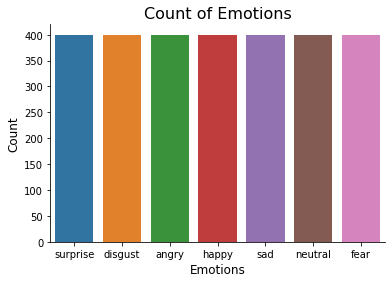

In [24]:
plt.title('Count of Emotions', size=16)
sns.countplot(Tess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [25]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

/content/drive/MyDrive/dataset_ml/TESS Toronto emotional speech set data/YAF_angry/YAF_chalk_angry.wav


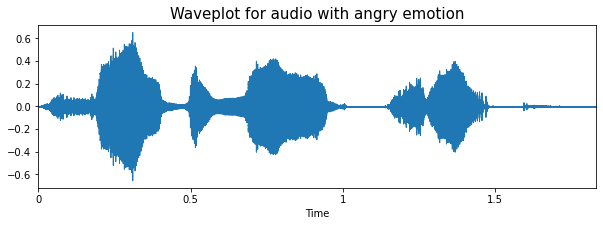

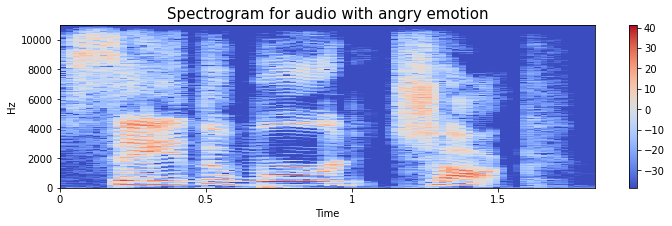

In [26]:
emotion="angry" #'fear'
path = np.array(Tess_df.Path[Tess_df.Emotions==emotion])[2]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

Robustecer el modelo y además contar con más ejemplo de entrenamiento (!deep learning lo necesita)

In [27]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate) #disminuye velocidad

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range) # cambia el orden del array, coloca en la posición shift_range al principio

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor) #modifica el tono

# taking any example and checking for techniques.
path = np.array(Tess_df.Path)[1]
data, sample_rate = librosa.load(path)

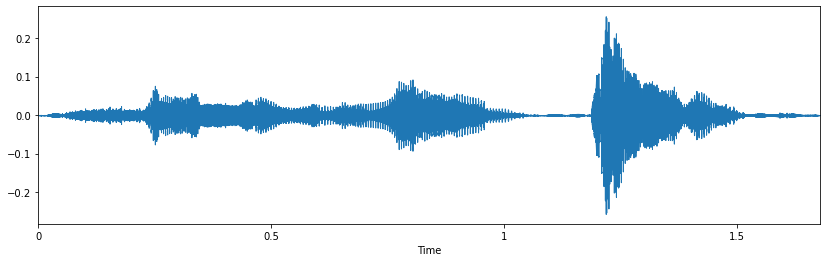

In [28]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

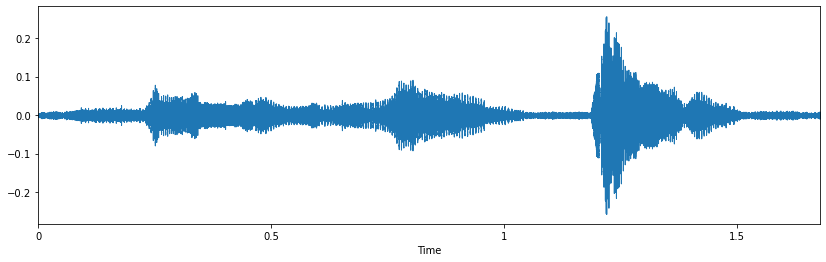

In [29]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

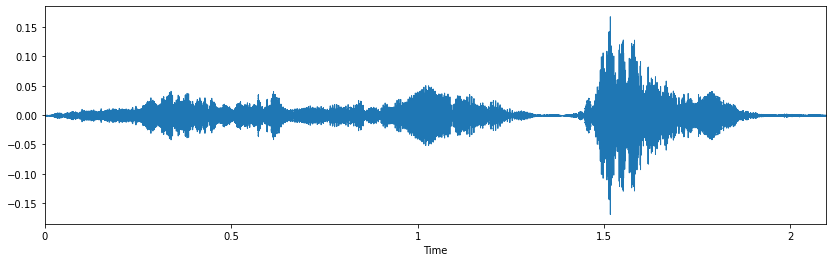

In [30]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

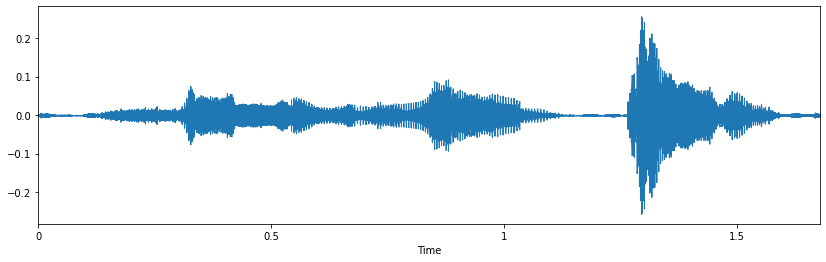

In [31]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

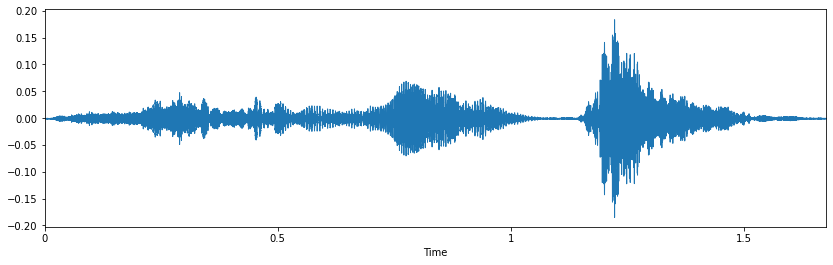

In [32]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

## Extracción de características

El problema es de 3 dimensiones, por lo que podemos trabajar en dos dominios distintos

La transformada rápida de Fourier es una herramienta que nos permite analizar el contenido de frecuencia de una señal, pero en este caso varía además con el tiempo! Estas señales se conocen como señales no periódicas. Necesitamos una forma de representar el espectro de estas señales a medida que varían con el tiempo.

La FFT se calcula en segmentos de ventana superpuestos de la señal, y obtenemos lo que se llama el espectrograma

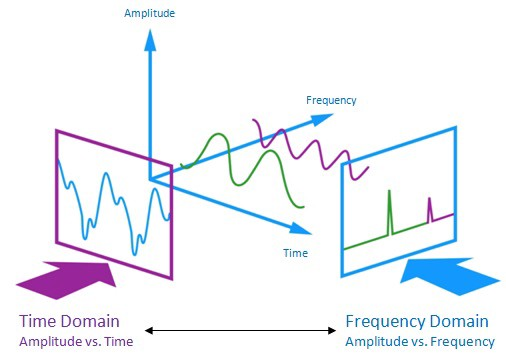

Ideas: 

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


[Mel spectogram](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)= Espectograma en una escala llamada mel. Un espectrograma como un montón de FFT apiladas una encima de la otra. Es una forma de representar visualmente el volumen o la amplitud de una señal, ya que varía con el tiempo a diferentes frecuencias. Hay muchos detalles adicionales detrás de escena cuando se calcula el espectrograma.

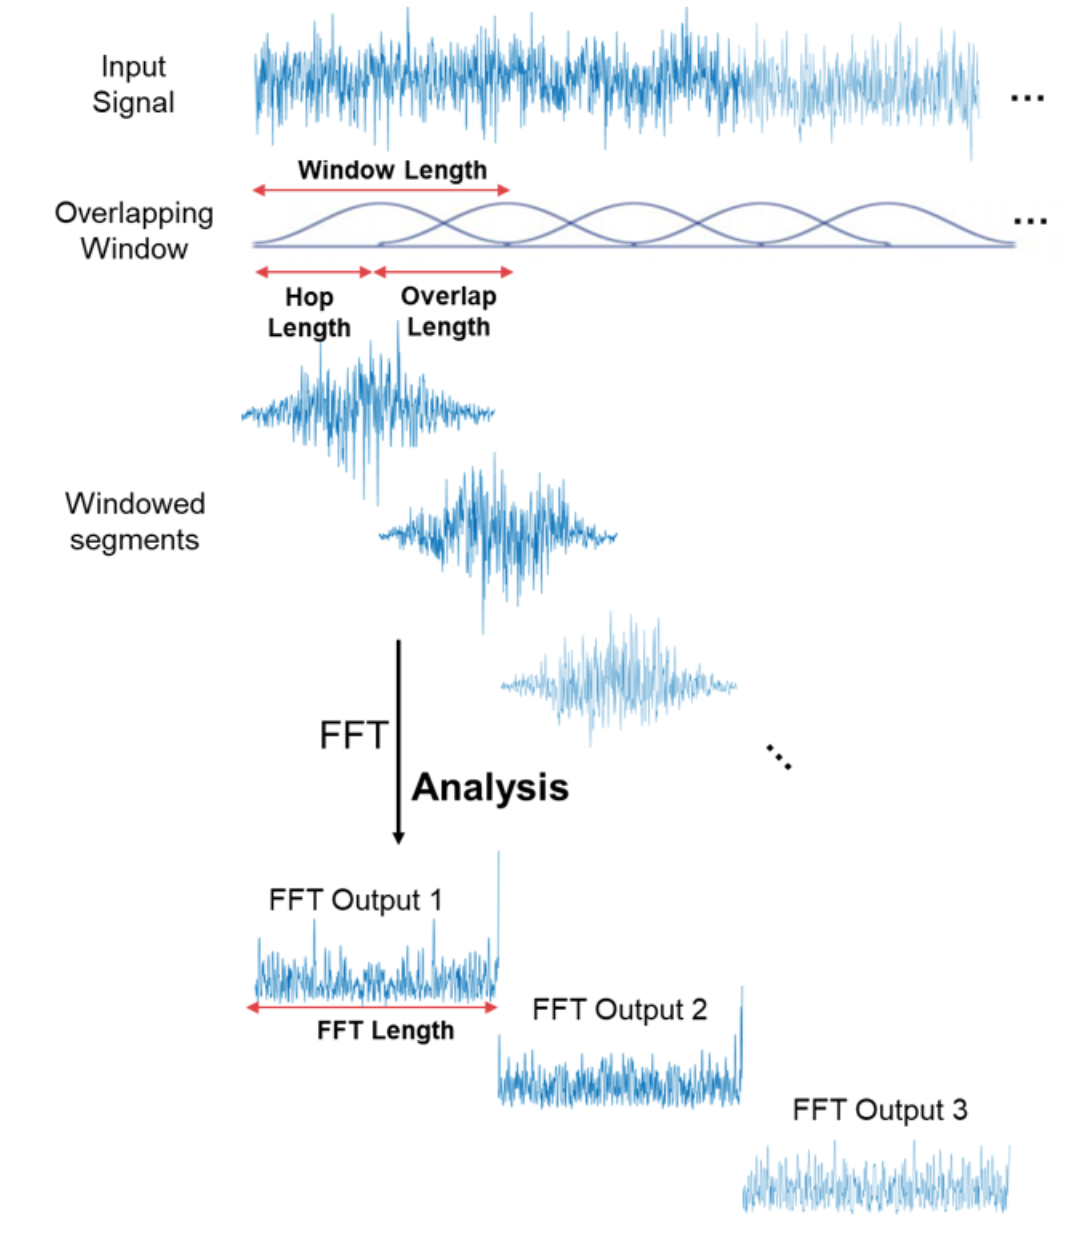

In [33]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0) #cuenta cambios de signo
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    #stft = np.abs(librosa.stft(data))
    #chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    #result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    #mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    #result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    #rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    #new_data = stretch(data)
    #data_stretch_pitch = pitch(new_data, sample_rate)
    #res3 = extract_features(data_stretch_pitch)
    #result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [34]:
X, Y = [], []
for path, emotion in zip(Tess_df.Path, Tess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

Se demoró 7 min

In [35]:
print(len(X), len(Y), Tess_df.Path.shape)

5600 5600 (2800,)


In [36]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.040996  0.145009  0.011719  0.002555  0.001474  0.029813  0.192575   
1  0.129423  0.145489  0.011772  0.002601  0.001606  0.030587  0.192306   
2  0.036611  8.856845  0.835596  0.070546  0.057212  0.041890  0.174418   
3  0.222313  8.820214  0.838429  0.070510  0.057310  0.042451  0.170314   
4  0.096730  1.547271  0.128144  0.004850  0.003326  0.020432  0.344395   

          7         8         9  ...       120       121       122       123  \
0  0.876660  0.469741  0.254475  ...  0.000044  0.000067  0.000061  0.000056   
1  0.872076  0.468712  0.253487  ...  0.000308  0.000349  0.000357  0.000341   
2  0.421249  0.463406  0.151326  ...  0.000071  0.000062  0.000118  0.000135   
3  0.421144  0.473553  0.158743  ...  0.001940  0.002182  0.002029  0.002219   
4  0.878157  0.238711  0.208135  ...  0.000207  0.000300  0.000367  0.000283   

        124       125       126       127           128    labels  
0  0.000120  0.000109  0.000030  0.000003  2.988496e-07  surprise  
1  0.000434  0.000396  0.000300  0.000271  2.928170e-04  surprise  
2  0.000082  0.000041  0.000032  0.000008  6.782457e-07  surprise  
3  0.002188  0.002081  0.002229  0.001992  2.031385e-03  surprise  
4  0.000372  0.000285  0.000198  0.000058  3.486556e-06  surprise  

[5 rows x 130 columns]

In [37]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4200, 129) (4200, 7) (1400, 129) (1400, 7)
(4200, 129, 1) (4200, 7) (1400, 129, 1) (1400, 7)


## Modelo

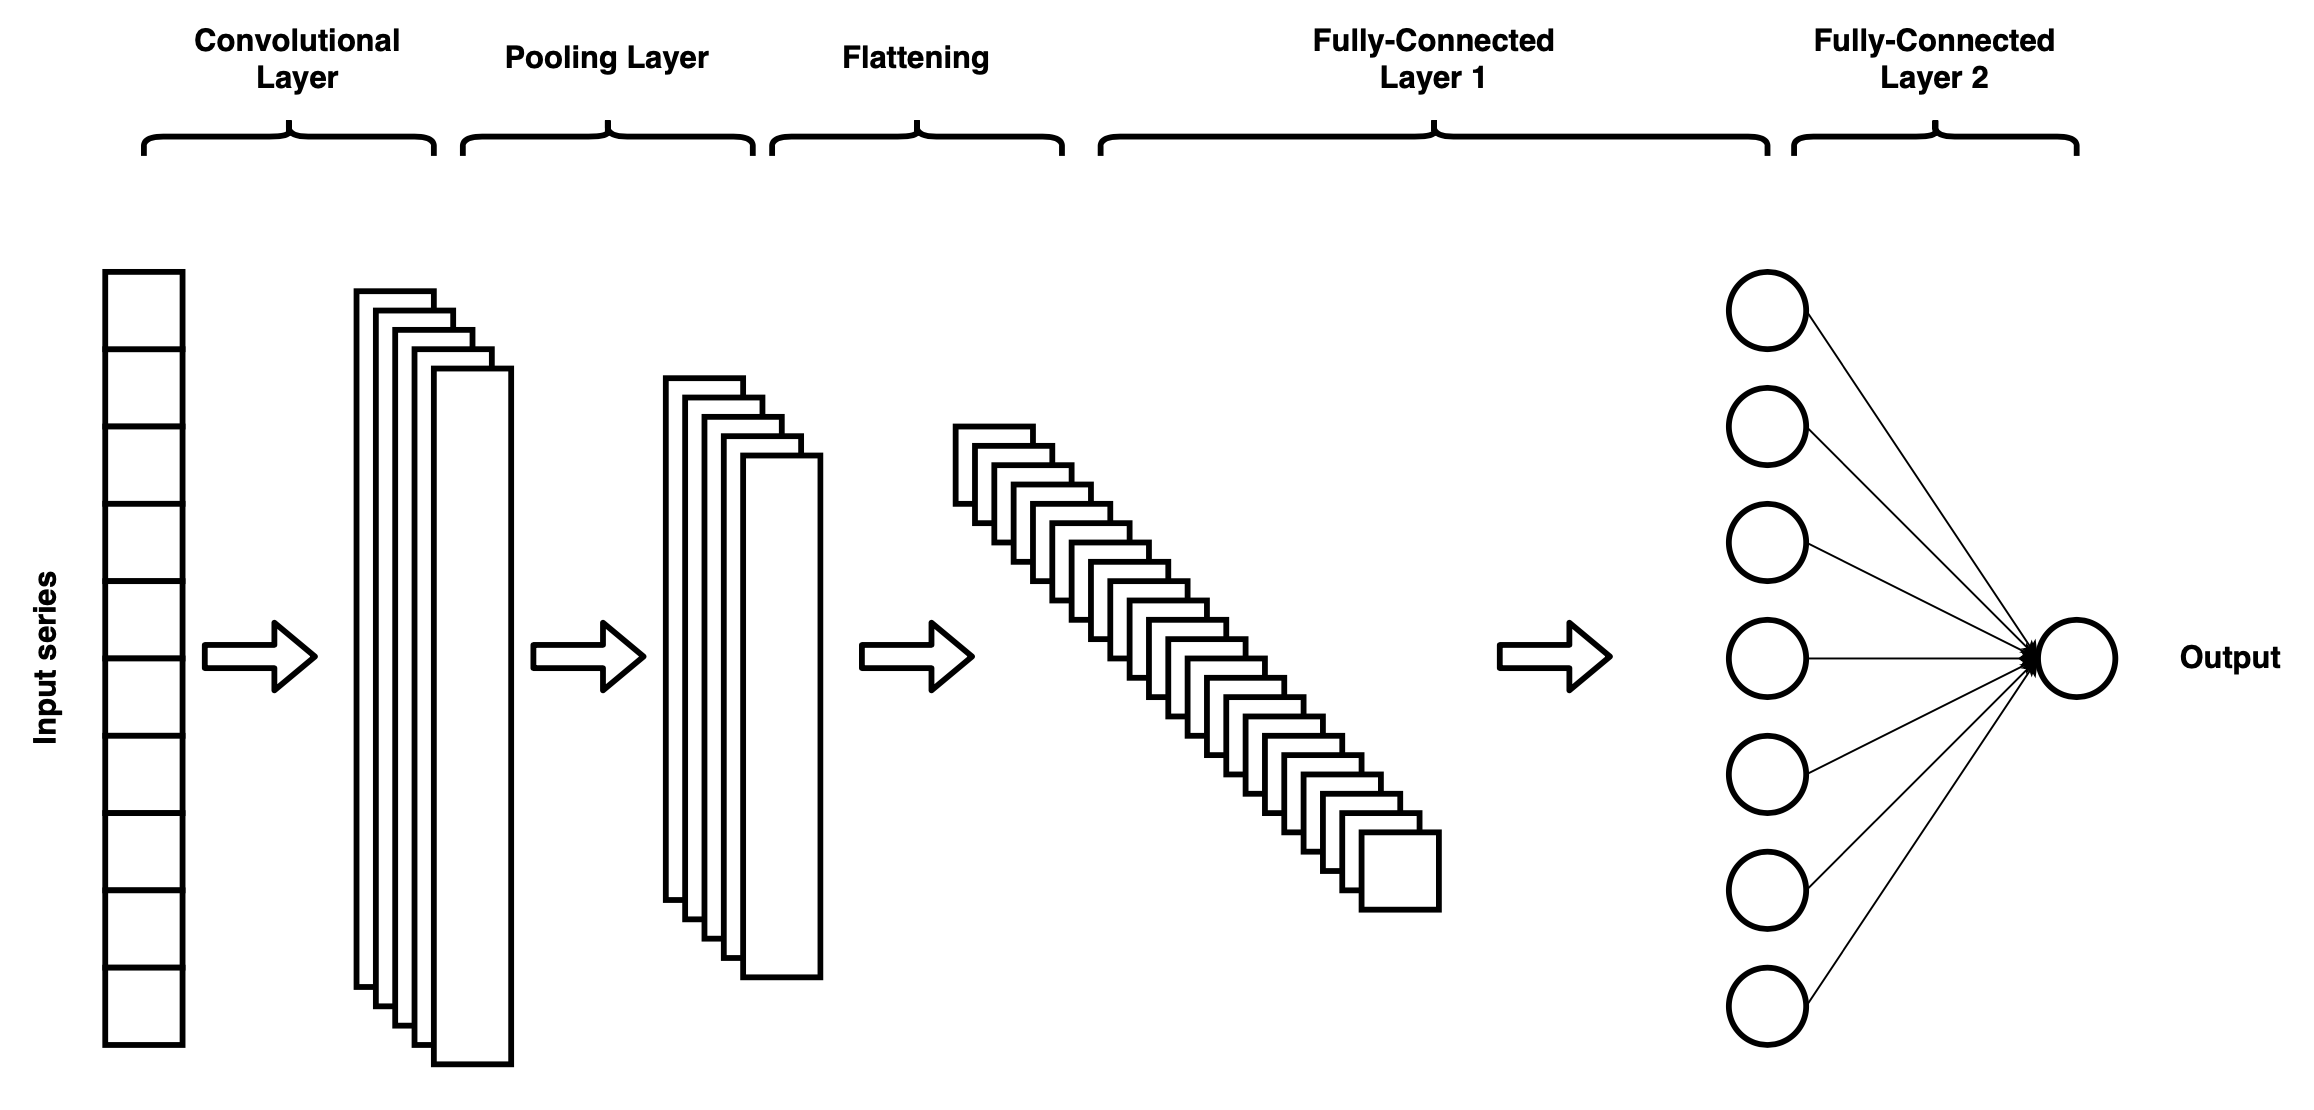

In [38]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax')) #numero de clases 
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 129, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 65, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 65, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 33, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 33, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17, 128)         

256*5+256

128*256 *5+128

64*128 *5+64

In [39]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
66/66 [==============================] - 9s 19ms/step - loss: 1.6657 - accuracy: 0.3252 - val_loss: 1.3210 - val_accuracy: 0.5357 - lr: 0.0010
Epoch 2/50
66/66 [==============================] - 1s 9ms/step - loss: 1.2267 - accuracy: 0.5329 - val_loss: 0.8633 - val_accuracy: 0.7429 - lr: 0.0010
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 0.8665 - accuracy: 0.6660 - val_loss: 0.6596 - val_accuracy: 0.7907 - lr: 0.0010
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 0.7185 - accuracy: 0.7229 - val_loss: 0.5719 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 5/50
66/66 [==============================] - 1s 11ms/step - loss: 0.6062 - accuracy: 0.7726 - val_loss: 0.4249 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 6/50
66/66 [==============================] - 1s 9ms/step - loss: 0.5055 - accuracy: 0.8067 - val_loss: 0.3992 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 7/50
66/66 [==============================] - 1s 9ms/step - loss: 0.4457

44/44 [==============================] - 0s 9ms/step - loss: 0.0780 - accuracy: 0.9829
Accuracy of our model on test data :  98.28571677207947 %


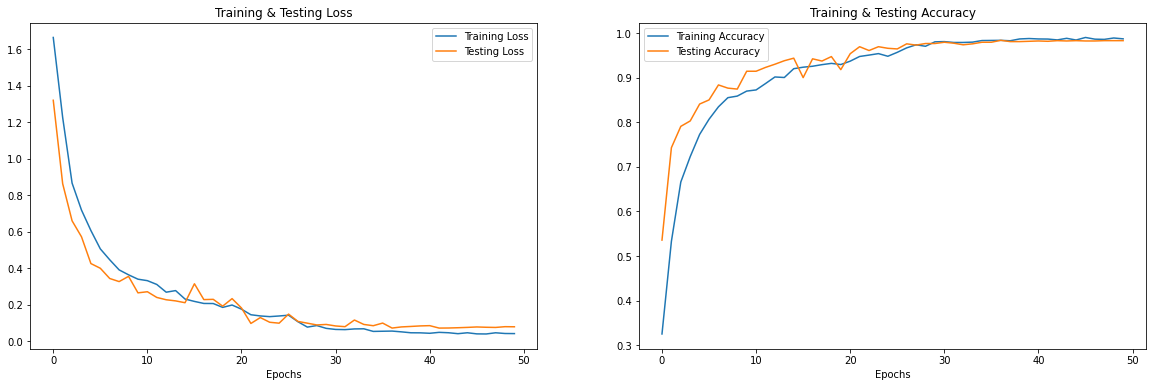

In [40]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [41]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [42]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          disgust       disgust
2            happy         happy
3            happy         happy
4          neutral       neutral
5          disgust       disgust
6             fear          fear
7              sad           sad
8             fear          fear
9             fear          fear

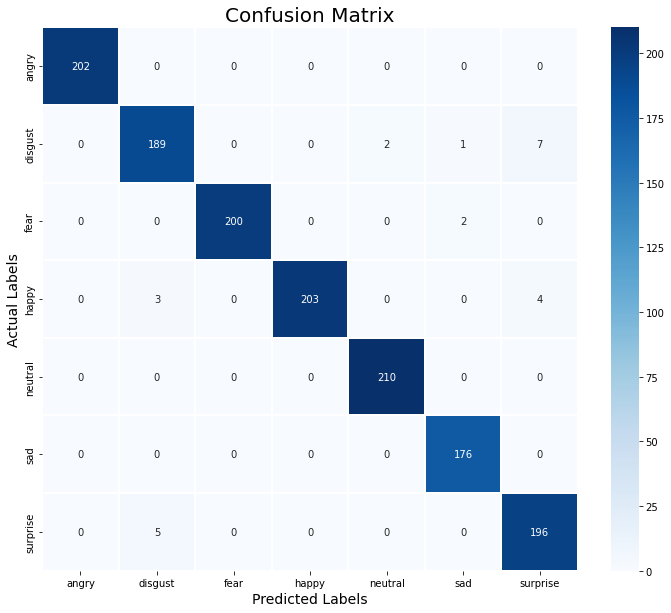

In [43]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [44]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       angry       1.00      1.00      1.00       202
     disgust       0.96      0.95      0.95       199
        fear       1.00      0.99      1.00       202
       happy       1.00      0.97      0.98       210
     neutral       0.99      1.00      1.00       210
         sad       0.98      1.00      0.99       176
    surprise       0.95      0.98      0.96       201

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



## Extra: Modelo pre entrenado

Instale las librerías con pip install + nombre

Modelo: https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-spanish

Datos: https://huggingface.co/datasets/common_voice/viewer/es/train

Origen de los datos: https://commonvoice.mozilla.org/en/datasets



In [46]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 5.7 MB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 6.6 MB 49.4 MB/s 
     |████████████████████████████████| 86 kB 6.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [47]:
import pandas as pd
import torch
import librosa
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

LANG_ID = "es"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-spanish"

processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

# Preprocessing the datasets.
# We need to read the audio files as arrays

speech_array, sampling_rate = librosa.load("ejemplo.mp3", sr=16_000)
batch= pd.DataFrame()
batch["speech"] = speech_array
inputs = processor(batch["speech"].values, sampling_rate=16_000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits


Downloading:   0%|          | 0.00/262 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/380 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [ ]:
batch["speech"].values.shape

In [49]:
predicted_ids = torch.argmax(logits, dim=-1)

predicted_sentences = processor.batch_decode(predicted_ids)

for i, predicted_sentence in enumerate(predicted_sentences):
    print("-" * 100)
    print("Prediction:", predicted_sentence)

----------------------------------------------------------------------------------------------------
Prediction: es la primera vez que veo a todos los chicos juntos haciendo algo


# 🎐 Predicción de la velocidad del viento 🎐

In [50]:
import datetime
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import tensorflow as tf

from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot, GRU, Attention

from keras.callbacks import History,EarlyStopping
from sklearn.metrics import mean_squared_error

In [51]:
# hacer la conexión a Google Drive

from google.colab import drive

colab_flag = True

if (colab_flag):
    drive.mount('/content/drive',force_remount=True)



path = '/content/drive/MyDrive/ANN-2021-I/'

Mounted at /content/drive


In [52]:
train= pd.read_csv(path+'velocidad-viento/windspeed-training.csv')
train.columns= ["Fecha","Velocidad"]
#train["Fecha"]= train.Fecha.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M'))

In [53]:
train.head()

Fecha  Velocidad
0  2012-12-19 00:10       12.4
1  2012-12-19 00:20       11.4
2  2012-12-19 00:30       11.8
3  2012-12-19 00:40       11.6
4  2012-12-19 00:50       11.0

In [54]:
j = 0
data = []
Traces = {
1 :'trace0'
}

Traces[0] = go.Scatter(
         x = train['Fecha'] ,
         y = train['Velocidad'],
         mode = 'lines',
         name = "Train"
     )
data.append(Traces[j]) 



layout = go.Layout(
      xaxis=dict(title='Fechas'),
      yaxis=dict(title='Velocidad'),
      title=('Velocidad...'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [55]:
def preprocesamiento(data, n_input, n_output, n_step):

  for i in range(0, data.shape[0]-n_input-n_output, n_step):
      salto= data.shape[0]-i-n_output
      x = data[salto-n_input:salto].reshape(1,n_input)
      y = data[salto: salto+n_output].reshape(1,n_output)
      if i == 0:
        X = x
        Y = y
      else:
        X = np.vstack((X,x))
        Y = np.vstack((Y,y))
  return X.reshape(X.shape[0], X.shape[1], 1), Y

In [56]:
velocidad_2015=train.iloc[119908:]

## Enconder-Decoder

In [57]:
def enc_dec(X_train,Y_train,X_val,Y_val):
  # define model
  model = Sequential()
  #encoder
  model.add(LSTM(50, activation='relu',name="encoder",dropout=0.2, recurrent_dropout=0.2, activity_regularizer=tf.keras.regularizers.l1(0.01),
                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None), input_shape=(X_train.shape[1], 1)))
  
  model.add(RepeatVector(dias_pred))

  #decoder
  model.add(LSTM(50, activation='relu',dropout=0.2, recurrent_dropout=0.2,
                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None), name="decoder",return_sequences=True))
  model.add(TimeDistributed(Dense(1)))

  model.compile(optimizer='adam', loss='mse')
  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history= model.fit(X_train, Y_train, epochs=100, verbose=1, batch_size=128,validation_data=(X_val,Y_val), callbacks= my_callbacks)
  x_input = X_val.reshape((X_val.shape[0], considerando, 1))
  yhat = model.predict(x_input, verbose=0)
  return yhat, history, model

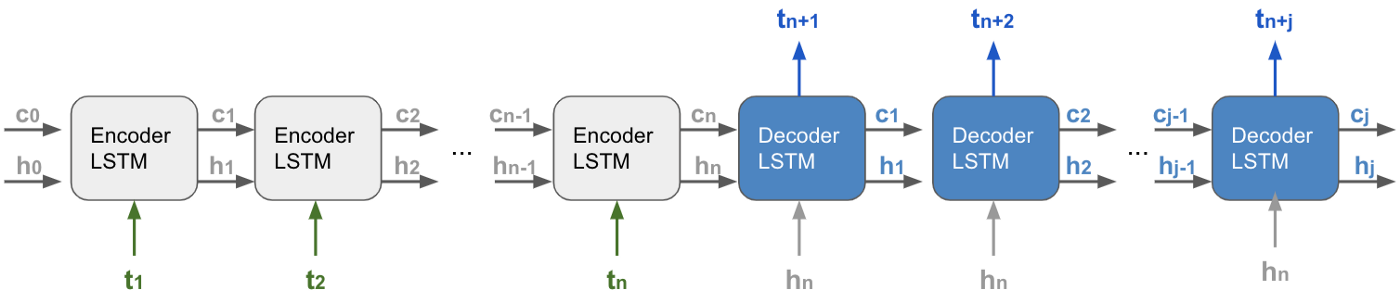

La capa RepeatVector se puede usar como un adaptador para unir las partes del codificador ( 2D, porque la salida de una LSTM es un vector de tamaño fijo que representa la representación interna de la secuencia de entrada. El número de celdas de memoria, simil a neuronas en el sentido de unidades de computo, en esta capa define la longitud de este vector de** tamaño fijo**) y del decodificador de la red (3D [muestras, pasos de tiempo, características] para producir una secuencia decodificada de alguna **longitud (variable)** diferente definida por el problema ). Podemos configurar el RepeatVector para repetir el vector de longitud fija una vez para cada paso de tiempo en la secuencia de salida.

Se pueden usar los mismos pesos para generar cada paso de tiempo en la secuencia de salida envolviendo la capa densa en un contenedor TimeDistributed.

https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

In [58]:
mse_ed, epoc_ed,mse_att,epoc_att= [],[],[],[]
dias=[72] #12 horas #,144,144*5,144*10]
considerando=144*5 #24horas*5 = 5 dias  #=720
for dias_pred in dias:
  print(dias_pred)
  X, Y= preprocesamiento(np.array(velocidad_2015.Velocidad).reshape(velocidad_2015.shape[0]) ,considerando,dias_pred,18) #18= 3 horas
  X_train, Y_train= X[:int(X.shape[0]*0.85)],Y[:int(X.shape[0]*0.85)]
  X_val, Y_val=X[int(X.shape[0]*0.85):],Y[int(X.shape[0]*0.85):] 
  print("data",X.shape,Y.shape)
  print("train",X_train.shape,Y_train.shape)
  print("val",X_val.shape,Y_val.shape)
  #normalizacion
  mu= np.mean(X_train)
  sigma= np.std(X_train)
  X_train= (X_train-mu)/sigma
  X_val= (X_val-mu)/sigma
  Y_train= (Y_train-mu)/sigma
  Y_val= (Y_val-mu)/sigma 

  y_enc_dec, history,model= enc_dec(X_train,Y_train,X_val,Y_val) 
  mse_ed.append(mean_squared_error(Y_val, y_enc_dec.reshape(Y_val.shape[0],dias_pred) ))
  epoc_ed.append(len(history.history["loss"]))



72
data (148, 720, 1) (148, 72)
train (125, 720, 1) (125, 72)
val (23, 720, 1) (23, 72)


Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.9943 - val_loss: 1.0671
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 0.9883 - val_loss: 1.0657
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 0.9813 - val_loss: 1.0653
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 0.9770 - val_loss: 1.0661
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 0.9744 - val_loss: 1.0670
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 0.9683 - val_loss: 1.0685


In [59]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (LSTM)              (None, 50)                10400     
                                                                 
 repeat_vector (RepeatVector  (None, 72, 50)           0         
 )                                                               
                                                                 
 decoder (LSTM)              (None, 72, 50)            20200     
                                                                 
 time_distributed (TimeDistr  (None, 72, 1)            51        
 ibuted)                                                         
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


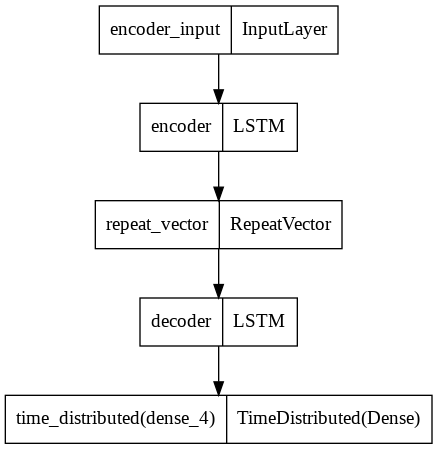

In [60]:
tf.keras.utils.plot_model(model)

## Atencion, nivel más avanzado

 https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb

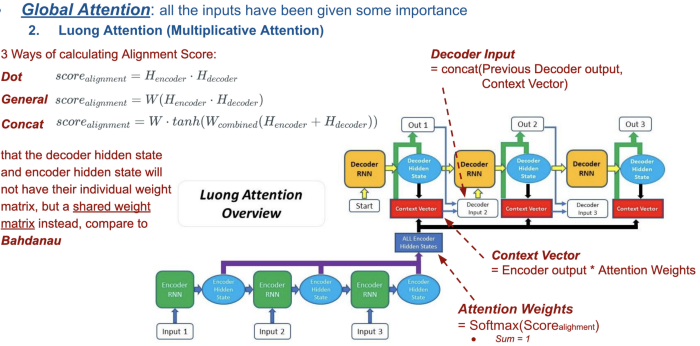

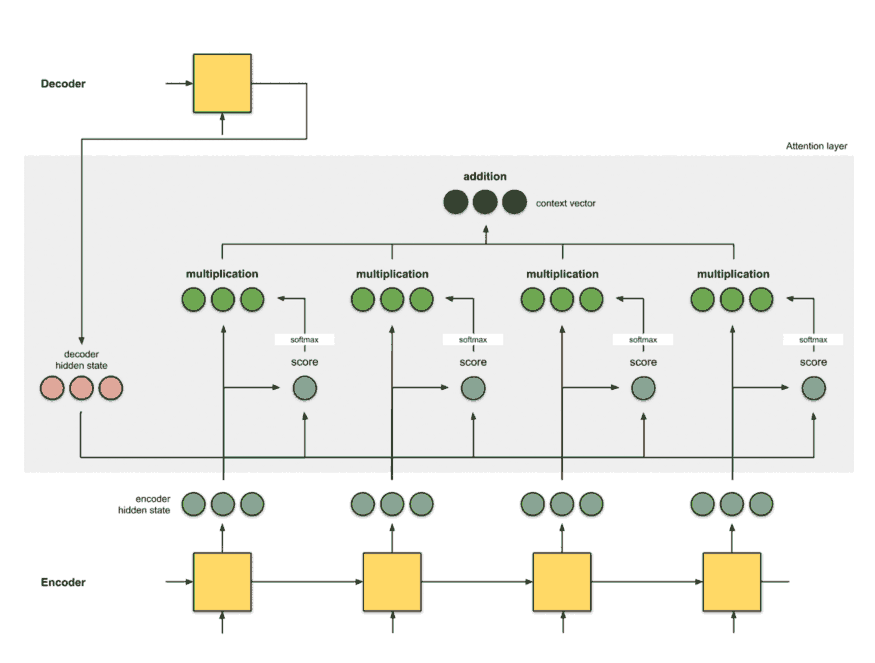

In [61]:
def atencionLuong(X_train, Y_train, X_test,Y_test,n_feautures=1):
  from keras.models import Model
  input_train = Input(shape=(X_train.shape[1], n_feautures))
  output_train = Input(shape=(Y_train.shape[1],n_feautures))

  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(50, activation='relu',dropout=0.2, recurrent_dropout=0.2, activity_regularizer=tf.keras.regularizers.l1(0.01),
                 kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None),name="encoder",return_state=True, return_sequences=True)(input_train)

  #print(encoder_stack_h)
  #print(encoder_last_h)
  #print(encoder_last_c)

  encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
  encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
  decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
  #print(decoder_input)

  decoder_stack_h = LSTM(50, activation='relu',name="decoder",dropout=0.2, recurrent_dropout=0.2,
                         kernel_initializer=tf.keras.initializers.GlorotNormal(seed=None),
                        return_state=False, return_sequences=True)(decoder_input, initial_state=[encoder_last_h, encoder_last_c])

  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_stack_h], axes=[2,1])
  context = BatchNormalization(momentum=0.6)(context)
  decoder_combined_context = concatenate([context, decoder_stack_h])
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
  model = Model(inputs=input_train, outputs=out)
  model.compile(optimizer='adam', loss='mse',metrics=["mse"])

  my_callbacks = [History(), EarlyStopping(patience=3, monitor="val_loss",restore_best_weights=True)]
  history=model.fit(X_train, Y_train, epochs=100, verbose=1,batch_size=128, validation_data=(X_test,Y_test), callbacks= my_callbacks)
  x_input = X_test.reshape((X_test.shape[0], X_train.shape[1], 1))
  y_pred = model.predict(x_input, verbose=0)
  return y_pred,history,model


In [62]:
y_att, history,model_a= atencionLuong(X_train,Y_train,X_val,Y_val) 
mse_att.append(mean_squared_error(Y_val, y_att.reshape(Y_val.shape[0],dias_pred)))
epoc_att.append(len(history.history["loss"]))

Epoch 1/100
1/1 [==============================] - 9s 9s/step - loss: 11.7357 - mse: 1.3745 - val_loss: 9.5805 - val_mse: 1.0454
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 11.0146 - mse: 1.2642 - val_loss: 9.0876 - val_mse: 1.0415
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 10.4313 - mse: 1.2203 - val_loss: 8.6368 - val_mse: 1.0396
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 9.7785 - mse: 1.1123 - val_loss: 8.2207 - val_mse: 1.0354
Epoch 5/100
1/1 [==============================] - 3s 3s/step - loss: 9.3037 - mse: 1.0627 - val_loss: 7.8405 - val_mse: 1.0296
Epoch 6/100
1/1 [==============================] - 3s 3s/step - loss: 8.8532 - mse: 1.0354 - val_loss: 7.4913 - val_mse: 1.0231
Epoch 7/100
1/1 [==============================] - 3s 3s/step - loss: 8.4697 - mse: 1.0240 - val_loss: 7.1670 - val_mse: 1.0160
Epoch 8/100
1/1 [==============================] - 3s 3s/step - loss: 8.0826 - mse: 1.0096 - val_loss

In [63]:
model_a.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 720, 1)]     0           []                               
                                                                                                  
 encoder (LSTM)                 [(None, 720, 50),    10400       ['input_1[0][0]']                
                                 (None, 50),                                                      
                                 (None, 50)]                                                      
                                                                                                  
 batch_normalization (BatchNorm  (None, 50)          200         ['encoder[0][1]']                
 alization)                                                                                   

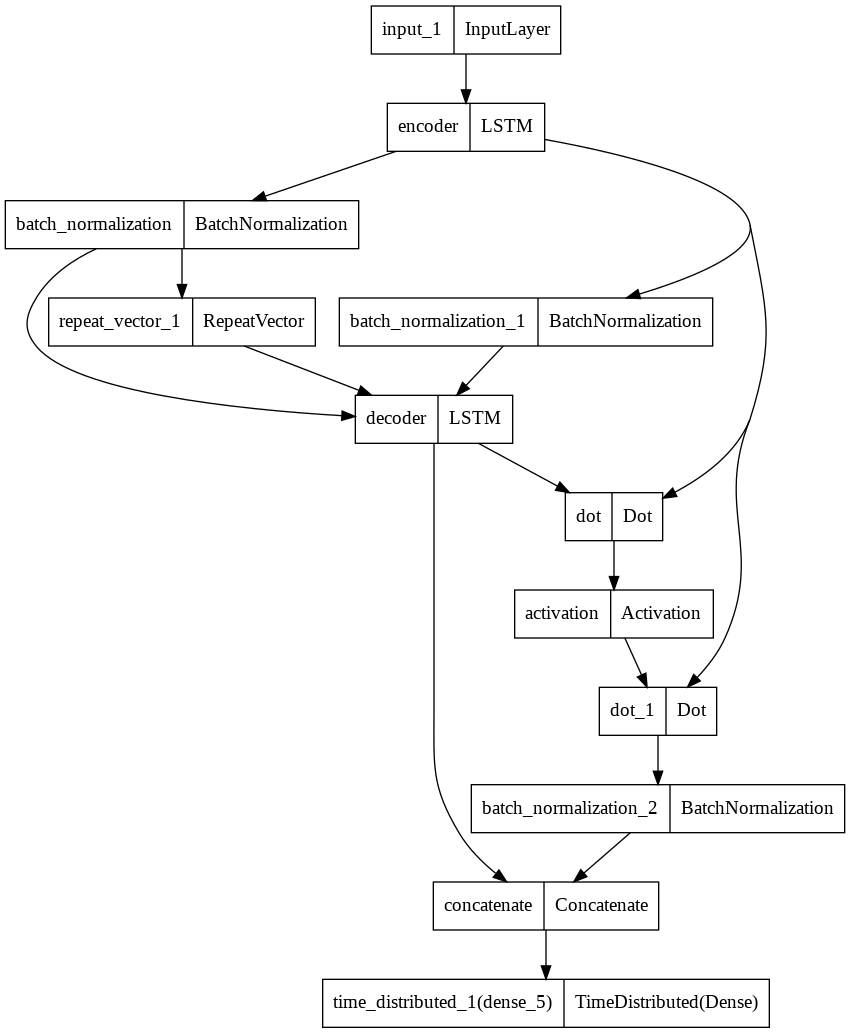

In [64]:
tf.keras.utils.plot_model(model_a)

In [65]:
print(mse_ed, mse_ed)

[1.0451672134556325] [1.0451672134556325]
